In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

import jsm_prephalo
import mcmc_aux
import galhalo
import os

from scipy import stats
from numpy.random import poisson
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
import mcmc_aux
import jsm_stats

In [3]:
data = mcmc_aux.mock_SAGA_survey([2,0.1,0.3], SAGA_ind=8)
data.get_stats(min_mass=6.5)

models = mcmc_aux.satgen_models([2,0.1,0.8], data.lgMh)
models.get_stats(min_mass=6.5)

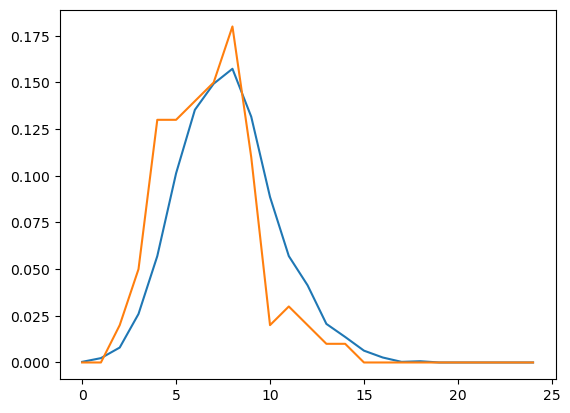

In [4]:
plt.plot(np.arange(models.stat.Pnsat.shape[0]), models.stat.Pnsat)
plt.plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat)
plt.show()

In [5]:
def lnL_Pnsat(model, data):
    return np.sum(np.log(model[data]))

In [6]:
lnL_Pnsat(models.stat.Pnsat, data.stat.satfreq)

-235.00665787293315

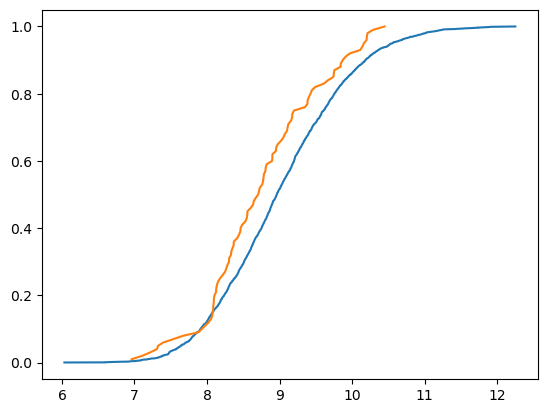

In [7]:
plt.plot(models.stat.Msmax, models.stat.ecdf_MsMax)
plt.plot(data.stat.Msmax, data.stat.ecdf_MsMax)

In [8]:
def lnL_KS(model, data):
    return np.log(ks_2samp(model, data)[1])

lnL_KS(models.stat.Msmax, data.stat.Msmax)

-4.294269823275624

In [9]:
alphas = np.linspace(1.1,3,100)
deltas = np.linspace(-0.2,1,100)
sigmas = np.linspace(0,2,5)


lnL_M = []
lnL_N = []

for i in deltas:
    models = mcmc_aux.satgen_models([1.9,i,0], data.lgMh)
    models.get_stats(min_mass=6.5)
    lnL_M.append(lnL_KS(models.stat.Msmax, data.stat.Msmax))
    lnL_N.append(lnL_Pnsat(models.stat.Pnsat, data.stat.satfreq))

lnL_M = np.array(lnL_M)
lnL_N = np.array(lnL_N)

# for i in alphas:
#     for j in deltas:
#         for k in sigmas:

In [10]:
lnL_N

array([         -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf, -369.43211542, -340.6429853 , -318.66060629,
       -300.5901957 , -284.46541351, -273.29307921, -263.57506419,
       -254.84835969, -246.66379878, -240.38108564, -235.955519  ,
       -232.14876696, -230.07654456, -228.37188963, -227.3679116 ,
       -227.40092778, -227.5795105 , -229.01878717, -231.18233788,
       -233.71745681,          -inf,          -inf, -243.44047983,
       -246.64831683, -250.79485641,          -inf,          -inf,
       -262.57151044, -267.56113542,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -

In [11]:
alphas.shape

(100,)

- Start with 3000 MW host halos -
Choose 100 of them to be the mock SAGA data.Assume what the universe looks like (decide on theta_0)
Run the mock data through the SHMR.
Measure the Nsat and Msmax statistics across the 100 hosts. This is the data, it does not change.

- With the remaining of the 2900 MW hosts -
Explore new values of theta (theta_i).
Measure the Nsat and Msmax statistics across the 2900 hosts. For each Nsat vector in a model, count the frequency and divide by 2900 to get a probability.This is the model. It is smoother than the data and in principle should be made up of as many MW hosts as possible.By assigning each count in the data its corresponding probability in the model, we can measure a likelihood.

- in a single step of the chain (one realization of theta_i):
DATA ( n = 100 values)data_vec = [2, 3, 0, 1, ... ]
MODEL (n = 18 values: the maximum number of satellites across all 2900 hosts - n might change depending on theta_i)Pmodel_vec = [0.01, 0.02, 0.05, 0.06, ...] Pmodel_index = [0, 1, 2, 3, ...]
PROBABILITY (n = 100 regardless of theta_i)
P(Nsat)_vec = [0.05, 0.06, 0.01, 0.02, ... ]The first value in the resulting probability vector would be 0.05 since the data shows only 2 satellites (n=2 index).
The second value would be 0.06, since the data shows 3 satellites (n=3 index). The third value would be 0.01, since the data shows 0 satellites (n=0 index). etc.
ln LIKELIHOOD ln L = ln ( product ( [0.05, 0.06, 0.01, 0.02, ... ] ))ln L = -271.32
SPECIAL CASESfor a given value of theta_i, the model might not have corresponding probabilities.
Let's say that theta_i: alpha=1.3, delta=-0.1, sigma=0. (moderately steep up curve - lots of galaxies predicted above 10^6.5)

issue is the model doesnt always have probabilites for every index correspoinding to the count!

https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/#

https://github.com/vinyluis/Articles/blob/main/Kolmogorov-Smirnov/Kolmogorov-Smirnov.ipynb

follow the above notebook to write your own!

okay so in combination these two statistics - the PDF of the number of satellites more massive than 6.5 and the CDF of the stellar mass of the most massive satellite - already encompas the halo to halo variance! each one of the stats is per host! that means that plotting the distribution shows how much each SAGA sample of 100 hosts differs. now to measure the likelyhood and combine them!

https://www.statisticshowto.com/likelihood-function-definition/